In [1]:
import pandas as pd
import numpy as np
from sklearn import model_selection, metrics, preprocessing
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

from torch_geometric.nn import LGConv

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
df = pd.read_csv('./MovieLens_Small/ratings.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [5]:
df['userId'].nunique()

610

In [6]:
df['movieId'].nunique()

9724

In [7]:
df['rating'].value_counts()

4.0    26818
3.0    20047
5.0    13211
3.5    13136
4.5     8551
2.0     7551
2.5     5550
1.0     2811
1.5     1791
0.5     1370
Name: rating, dtype: int64

In [8]:
df['rating'].mean()

3.501556983616962

In [9]:
df.shape

(100836, 4)

In [10]:
df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [11]:
class MovieDataset:
    def __init__(self, users, movies, ratings) -> None:
        self.users = users
        self.movies = movies
        self.ratings = ratings

    def __len__(self) -> int:
        return len(self.users)

    def __getitem__(self, item) -> dict:

        users = self.users[item]
        movies = self.movies[item]
        ratings = self.ratings[item]

        return {
            "users": torch.tensor(users), #dtype=torch.long
            "movies": torch.tensor(movies), #dtype=torch.long
            "ratings": torch.tensor(ratings) #dtype=torch.long
        }

In [12]:
class RecSysModel(nn.Module):
    def __init__(self, n_users, n_movies) -> None:
        super().__init__()
        self.user_embed = nn.Embedding(n_users, 32)
        self.movie_embed = nn.Embedding(n_movies, 32)
        self.out = nn.Linear(64, 1)

    def forward(self, users, movies, ratings=None):
        user_embeds = self.user_embed(users)
        movie_embeds = self.movie_embed(movies)
        output = torch.cat([user_embeds, movie_embeds], dim=1)
        output = self.out(output)

        return output

In [ ]:
# class LightGCN(nn.Module):
#     def __init__(self, n_users, n_movies) -> None:
#         super().__init__()
#         self.user_embed = nn.Embedding(n_users, 64)
#         self.movie_embed = nn.Embedding(n_movies, 64)
#         self.light_conv = LGConv()

In [13]:
lbl_user = preprocessing.LabelEncoder()
lbl_movie = preprocessing.LabelEncoder()
df['userId'] = lbl_user.fit_transform(df['userId'].values)
df['movieId'] = lbl_movie.fit_transform(df['movieId'].values)

In [14]:
df_train, df_val = model_selection.train_test_split(
    df, test_size=0.1, random_state=33, stratify=df['rating'].values
)

train_dataset = MovieDataset(
    users=df_train['userId'].values,
    movies=df_train['movieId'].values,
    ratings=df_train['rating'].values
)

val_dataset = MovieDataset(
    users=df_val['userId'].values,
    movies=df_val['movieId'].values,
    ratings=df_val['rating'].values
)

In [15]:
train_dataset.__getitem__(0)

{'users': tensor(413),
 'movies': tensor(2098),
 'ratings': tensor(2., dtype=torch.float64)}

In [16]:
BATCH_SIZE = 4
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True)



In [17]:
data_iter = iter(train_loader)
dataloader_data = data_iter.next()
print(dataloader_data)

{'users': tensor([273, 419, 203, 225]), 'movies': tensor([ 396, 4631,  254, 1971]), 'ratings': tensor([2.0000, 3.5000, 4.5000, 3.5000], dtype=torch.float64)}


In [18]:
model = RecSysModel(
    n_users=len(lbl_user.classes_),
    n_movies=len(lbl_movie.classes_)
).to(device)

optimizer = torch.optim.Adam(model.parameters())
# sch = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.7)

loss_func = nn.MSELoss()

In [19]:
print(len(lbl_user.classes_))
print(len(lbl_movie.classes_))


610
9724


### Manual forward feed

In [20]:
print(dataloader_data['users'])
print(dataloader_data['users'].size())

print(dataloader_data['movies'])
print(dataloader_data['movies'].size())


tensor([273, 419, 203, 225])
torch.Size([4])
tensor([ 396, 4631,  254, 1971])
torch.Size([4])


In [21]:
user_embed = nn.Embedding(len(lbl_user.classes_), 32)
movie_embed = nn.Embedding(len(lbl_movie.classes_), 32)
out = nn.Linear(64, 1)

user_embeds = user_embed(dataloader_data['users'])
movie_embeds = movie_embed(dataloader_data['movies'])

print(f'user_embeds {user_embeds.size()}')
print(f'user_embeds {user_embeds}')
print(f'movie_embed {movie_embeds.size()}')
print(f'movie_embed {movie_embeds}')


user_embeds torch.Size([4, 32])
user_embeds tensor([[ 0.0450, -0.7852, -1.1599,  0.5828,  0.7884, -0.6100, -0.5064, -1.0938,
         -0.7622,  1.1364, -0.1083, -1.7914,  0.4364,  0.4018, -0.1500, -0.4092,
          1.1111,  1.3063,  0.1889,  0.3280, -1.9224, -1.4026,  1.7069, -0.0503,
         -1.4928,  1.5954,  0.8533,  0.4914,  0.6853, -0.9829,  0.0698, -1.9679],
        [-0.3540, -1.2554,  0.9833,  0.8981,  0.6045, -0.3823, -0.4571, -1.0744,
          1.1091,  2.0317,  0.4881, -1.2445,  0.1699, -0.3471,  0.6734, -0.2391,
          0.2148, -0.5045,  1.1946, -1.8971,  0.5803, -2.1773,  0.7324,  0.1218,
         -0.5294, -1.5855, -0.5290,  0.2420, -2.8364,  1.6015,  1.5537,  0.5609],
        [ 1.4268,  0.1016,  0.3372,  1.8104, -0.8071,  1.3596,  1.0762,  0.6669,
          0.6916,  0.1359,  2.7607, -0.4542, -0.6537,  1.5405, -0.1719, -0.2094,
         -0.4690,  0.5374,  0.9338, -0.5704, -2.1185,  0.2338,  1.7026,  0.0774,
         -1.1908,  0.4303,  0.6154, -0.1205, -0.9766, -1.5517, 

In [22]:
output = torch.cat([user_embeds, movie_embeds], dim=1)
print(f'Output: {output.size()}')
print(f'Output: {output}')



Output: torch.Size([4, 64])
Output: tensor([[ 0.0450, -0.7852, -1.1599,  0.5828,  0.7884, -0.6100, -0.5064, -1.0938,
         -0.7622,  1.1364, -0.1083, -1.7914,  0.4364,  0.4018, -0.1500, -0.4092,
          1.1111,  1.3063,  0.1889,  0.3280, -1.9224, -1.4026,  1.7069, -0.0503,
         -1.4928,  1.5954,  0.8533,  0.4914,  0.6853, -0.9829,  0.0698, -1.9679,
          0.0045,  1.6305,  0.6263, -1.2938,  0.7370, -0.0987, -0.0097, -0.4281,
          1.5533,  0.9429,  0.3960,  0.2052,  0.1893,  0.3315, -0.7392,  0.8112,
         -0.8164, -0.5467,  1.1210,  1.6635, -2.2354,  0.3385,  0.3033,  1.4530,
          0.1614,  0.5271, -0.6734, -1.7363,  1.1609, -0.1029,  0.1587, -0.9660],
        [-0.3540, -1.2554,  0.9833,  0.8981,  0.6045, -0.3823, -0.4571, -1.0744,
          1.1091,  2.0317,  0.4881, -1.2445,  0.1699, -0.3471,  0.6734, -0.2391,
          0.2148, -0.5045,  1.1946, -1.8971,  0.5803, -2.1773,  0.7324,  0.1218,
         -0.5294, -1.5855, -0.5290,  0.2420, -2.8364,  1.6015,  1.5537, 

In [23]:
output = out(output)
print(f'Output: {output}')

Output: tensor([[-0.6038],
        [-0.1483],
        [ 0.2257],
        [-0.4383]], grad_fn=<AddmmBackward0>)


In [24]:
with torch.no_grad():
    model_output = model(dataloader_data['users'], dataloader_data['movies'])
    print(f'model output: {model_output}, size: {model_output.size()}')

model output: tensor([[ 0.1376],
        [-1.0458],
        [-0.1109],
        [ 0.5517]]), size: torch.Size([4, 1])


In [25]:
rating = dataloader_data['ratings']
print(rating)
print(rating.view(4, -1))
print(model_output)

print(rating.sum())
print(model_output.sum() - rating.sum())

tensor([2.0000, 3.5000, 4.5000, 3.5000], dtype=torch.float64)
tensor([[2.0000],
        [3.5000],
        [4.5000],
        [3.5000]], dtype=torch.float64)
tensor([[ 0.1376],
        [-1.0458],
        [-0.1109],
        [ 0.5517]])
tensor(13.5000, dtype=torch.float64)
tensor(-13.9673, dtype=torch.float64)


### Train

In [26]:
epochs = 1
total_loss = 0
plot_steps, print_steps = 5000, 5000
step_cnt = 0
all_losses_list = []

model.train()
for epoch in range(epochs):
    for i, train_data in enumerate(train_loader):
        output = model(train_data['users'], 
                       train_data['movies']
                       )

        rating = train_data['ratings'].view(4, -1).to(torch.float32)

        loss = loss_func(output, rating)
        total_loss += loss.sum().item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        step_cnt += len(train_data['users'])

        if step_cnt % plot_steps == 0:
            avg_loss = total_loss / (len(train_data['users']) * plot_steps)
            print(f'Epoch: {epoch} loss at step: {step_cnt} is {round(avg_loss, 4)}')
            all_losses_list.append(avg_loss)
            total_loss = 0

Epoch: 0 loss at step: 5000 is 0.5533
Epoch: 0 loss at step: 10000 is 0.197
Epoch: 0 loss at step: 15000 is 0.1081
Epoch: 0 loss at step: 20000 is 0.0821
Epoch: 0 loss at step: 25000 is 0.069
Epoch: 0 loss at step: 30000 is 0.0618
Epoch: 0 loss at step: 35000 is 0.062
Epoch: 0 loss at step: 40000 is 0.0572
Epoch: 0 loss at step: 45000 is 0.057
Epoch: 0 loss at step: 50000 is 0.0543
Epoch: 0 loss at step: 55000 is 0.0548
Epoch: 0 loss at step: 60000 is 0.054
Epoch: 0 loss at step: 65000 is 0.0544
Epoch: 0 loss at step: 70000 is 0.0535
Epoch: 0 loss at step: 75000 is 0.0513
Epoch: 0 loss at step: 80000 is 0.0518
Epoch: 0 loss at step: 85000 is 0.0528
Epoch: 0 loss at step: 90000 is 0.0503


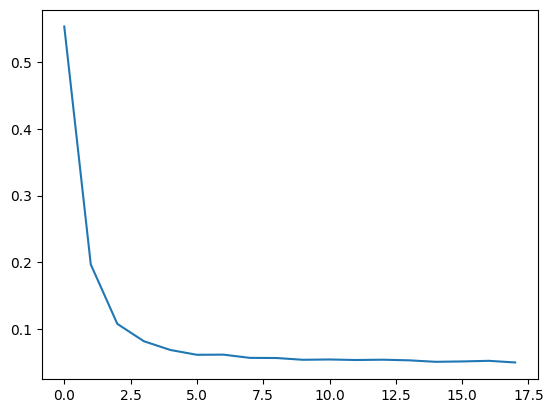

In [27]:
plt.figure()
plt.plot(all_losses_list)
plt.show()

### Evaluation

In [33]:
from sklearn.metrics import mean_squared_error

model_output_list = []
target_rating_list = []

model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        model_output = model(val_data['users'],
                             val_data['movies'])
        
        model_output_list.append(model_output.sum().item() / len(val_data['users']))
        target_rating = val_data['ratings']
        target_rating_list.append(target_rating.sum().item() / len(val_data['users']))

        print(f'model_output:\t{model_output.view(4,)}\ntarget_rating:\t{target_rating}\n')

rms = mean_squared_error(target_rating_list, model_output_list, squared=False)
print(f'rms: {rms}')

model_output:	tensor([2.8996, 2.8622, 3.9969, 3.6472])
target_rating:	tensor([3., 1., 3., 4.], dtype=torch.float64)

model_output:	tensor([3.9082, 3.6264, 4.3248, 2.2612])
target_rating:	tensor([2.0000, 4.5000, 4.0000, 3.0000], dtype=torch.float64)

model_output:	tensor([3.7371, 4.6482, 4.3031, 3.6005])
target_rating:	tensor([3.0000, 5.0000, 3.5000, 4.0000], dtype=torch.float64)

model_output:	tensor([3.1453, 2.8160, 3.8378, 3.8971])
target_rating:	tensor([2.0000, 2.5000, 4.0000, 3.5000], dtype=torch.float64)

model_output:	tensor([3.9262, 4.1531, 3.4831, 3.9827])
target_rating:	tensor([3.5000, 5.0000, 3.0000, 4.0000], dtype=torch.float64)

model_output:	tensor([3.3985, 3.9916, 3.4890, 2.8130])
target_rating:	tensor([3.5000, 4.0000, 3.0000, 0.5000], dtype=torch.float64)

model_output:	tensor([3.3202, 4.1728, 3.3833, 3.1558])
target_rating:	tensor([3.5000, 4.0000, 3.0000, 3.0000], dtype=torch.float64)

model_output:	tensor([4.2474, 3.2425, 3.0965, 3.4458])
target_rating:	tensor([4.5000,

In [39]:
from collections import defaultdict

user_est_true = defaultdict(list)

with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        users = val_data['users']
        movies = val_data['movies']
        ratings = val_data['ratings']

        model_output = model(val_data['users'],
                             val_data['movies'])

        for i in range(len(users)):
            user_id = users[i].item()
            movie_id = movies[i].item()
            pred_rating = model_output[i][0].item()
            true_rating = ratings[i].item()

            print(f'{user_id}, {movie_id}, {pred_rating}, {true_rating}')
            user_est_true[user_id].append((pred_rating, true_rating))

9, 4636, 3.1948564052581787, 4.0
10, 5, 3.860163688659668, 5.0
201, 1434, 3.941141128540039, 4.0
554, 1109, 3.0729734897613525, 3.0
376, 3181, 3.7810587882995605, 5.0
306, 4125, 2.5117530822753906, 0.5
380, 3197, 3.0359737873077393, 3.5
473, 5204, 3.4608960151672363, 3.0
225, 944, 3.7141737937927246, 4.0
403, 325, 3.2778804302215576, 3.0
468, 2873, 3.4823310375213623, 2.0
67, 4542, 2.987069845199585, 1.5
599, 483, 3.195197105407715, 4.0
379, 959, 4.313747406005859, 5.0
378, 472, 3.0231029987335205, 4.0
317, 5037, 3.6698286533355713, 3.5
386, 2216, 3.493391513824463, 4.0
424, 2601, 3.6713504791259766, 3.0
516, 2345, 2.745321035385132, 2.0
317, 172, 3.4912827014923096, 3.5
540, 459, 3.2418313026428223, 4.0
124, 8847, 3.703899383544922, 3.5
364, 8897, 2.8356525897979736, 4.0
516, 2144, 2.880565643310547, 1.0
553, 510, 4.450370788574219, 5.0
447, 7263, 2.7048182487487793, 3.0
479, 986, 3.5489227771759033, 4.0
473, 2739, 3.6437301635742188, 3.5
317, 6353, 3.6004981994628906, 4.0
287, 2533, 

In [74]:
with torch.no_grad():
    precisions = dict()
    recalls = dict()

    k = 20
    threshold = 3.4

    for uid, user_ratings in user_est_true.items():
        # print(uid, user_ratings)
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        # print(uid, user_ratings)

        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        n_rec_k = sum((true_r >= threshold) for (_, true_r) in user_ratings[:k])
        # print(n_rel, n_rec_k)

        n_rel_and_rec_k = sum(
            ((true_r >= threshold) and (est >= threshold))
            for (est, true_r) in user_ratings[:k]
        )
        
        # print(f'uid: {uid}, n_rel: {n_rel}, n_rec_k: {n_rec_k}, n_rel_and_rec_k: {n_rel_and_rec_k}')
        
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
        # break

In [75]:
print(f'precisions @ {k}: {sum(prec for prec in precisions.values()) / len(precisions)}')
print(f'recall @ {k}: {sum(rec for rec in recalls.values()) / len(recalls)}')


precisions @ 20: 0.7145363196534649
recall @ 20: 0.6444319685446616
